
## Graph Neural Network for Subsurface Modeling

#### Wendi Liu
####  Hildebrand Department of Petroleum and Geosystems Engineering

### Subsurface Machine Learning Course, The University of Texas at Austin




_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Ademide Mabadeje, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/ademidemabadeje/)


### Executive Summary

Hard data like well samples or core measurements are sparse in the scale of reservoir and data sparsity poses challenge in reservoir modeling and segmentation. I propose to use graph neural network with sparse well sample as graph input to assist facies segmentation. The pretrained model should be able to predict facies of a well given location. The graph neural network could take advantage of the spatial continuity integrated from well graph and therefore have an improved performance.


### Import Packages

Note, you may need to install pytorch and dgl first in order to run this workflow. Installation instruction can be found here: https://docs.dgl.ai/en/0.6.x/install/

In [1]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt                          
import random as rand
import math
import geostatspy.GSLIB as GSLIB                       # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats                 # GSLIB methods convert to Python
from copy import copy
import dgl     #API for GNN
from dgl.nn.pytorch import GraphConv
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import networkx as nx   #visualize graph
from dgl.data import DGLDataset
import dgl.function as fn

Using backend: pytorch


### Load Data

The following workflow applies the .csv file 'samples.csv' and 'graph_df', two synthetic datasets.
We will work with the following features:

**samples.csv**
* **porosity** - fraction of rock void in units of percentage
* **permeability** - ability of a fluid to flow through the rock in miliDarcy
* **acoustic impedence** - product of sonic velocity and rock density in units of $kg/m^2s*10^3$
* **facies** -  rock facies labeled with 0 and 1 for shale and sand

**graph_df.csv**
* **src** - source node index for the edge
* **dst** - destination node index for the edge
* **weight** - weight of the edge based on physics constraint


In [2]:
graph_edges = pd.read_csv('https://raw.githubusercontent.com/whenn0406/Synthetic_GeoDatasets/main/graph_df.csv')
samples = pd.read_csv('https://raw.githubusercontent.com/whenn0406/Synthetic_GeoDatasets/main/samples.csv')

#### Visualize data and graph edges

The edges between nodes in the plot are scaled by weight

Text(0, 0.5, 'Y')

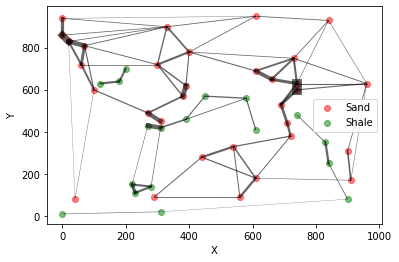

In [3]:
for _, local in graph_edges.iterrows():
    plt.plot([samples.loc[local['src']].X,samples.loc[local['dst']].X],[samples.loc[local['src']].Y,samples.loc[local['dst']].Y],
    color = 'black', alpha = 0.6, linewidth = local['weight']*120)
plt.scatter(samples[samples['Facies'] == 1.0 ]['X'],samples[samples['Facies'] == 1.0 ]['Y'], c='r', alpha = 0.5, label = 'Sand')
plt.scatter(samples[samples['Facies'] == 0.0 ]['X'],samples[samples['Facies'] == 0.0 ]['Y'], c='g', alpha = 0.5, label = 'Shale')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')

### Method

Graphs are a type of data structure that models a set of objects (nodes or vertices) and their relationships (edges) (Biggs et al. 1986). Graphs can describe a large number of systems across diverse areas, including social networks, physical structures and spatial networks. Graph neural networks retain the expressive power and interpretability of graphs, as well as the convincing performance of fully connected neural networks

The fundamental architecture of GNN can be described in 

$v_A^{(k+1)} = \sigma (W^{(k)}v_A^{(k)}, AGG_{x\in N(A)}(\sigma(q^{(k)}v_x^{(k)})))$, 

where $v_A^{(k+1)}$ is the k+1 level embedding of node A, $\sigma (\cdot)$ is the activation function, $W^{(k)}v_A^{(k)}$ transforms A's own embedding from level k, $AGG_{x\in N(A)}(\sigma(q^{(k)}v_x^{(k)}))$ transforms and aggregates embeddings of neighbors x at level k for node A, denoted as $x\in N(A)$. $v_A^{(0)}$is the initial layer embeddings, which is equal to the features of node A.

Neural networks like CNNs or RNNs can only operate on Euclidean data, i.e., 2D grid or 1D sequence, while GNNs generalize the application of neural networks to non-Euclidean data with complex topology and enrich the information of a given node using the information from neighboring nodes. Within a few number of hops ($k$, usually within 3-4), GNN can traverse all the nodes and aggregate the information from neighbors, which is more computationally efficient than other neural networks (Kipf and Welling 2016).

In this demonstration, I will 

* First, construct graph input based on the well connections
* Build graph convolutional neural network architecture. We use a GNN API called DGL to build the GCN model. The general GCN layer consists of the following 3 steps (https://keras.io/examples/graph/gnn_citations/)
    * **Message passing**: The input node representations are processed using a feedforward network to produce a message.
    * **Aggregate**: The messages of the neighbours of each node are aggregated with respect to the edge weights using a permutation invariant pooling operation, such as sum, mean, and max, to prepare a single aggregated message for each node.
    * **Update**: The node repesentations and aggregated messages are combined and processed through another feedforward network to produce the new state of the node representations (node embeddings). 
    * The above steps is wrapped in the API **GraphConv**
* Train the GCN model:
    * In graph construction, I applied a mask to separate the nodes for training and testing
* Visualize the results

#### Construct graph 

We load dataframe from the csv file and save as graph class for the graph neural network to take as input. 

The graph structure contains:

* **Node features**: Porosity, acoustic impedance and permeability loaded from sample.csv
* **Node labels**: Facies category loaded from sample.csv
* **Edge features**: Edge weights loaded from graph.csv
* **Edge source and destination**: Edge source and destination index loaded from the graph.csv. 

reference: https://docs.dgl.ai/en/0.6.x/tutorials/blitz/6_load_data.html#sphx-glr-tutorials-blitz-6-load-data-py

In [4]:
class facies_graph(DGLDataset):
    def __init__(self):
        super().__init__(name='variogram_based_graph')

    def process(self):
        nodes_data = samples
        edges_data = graph_edges
        node_features = torch.from_numpy(nodes_data.loc[:,['Por', 'AI','Perm']].to_numpy())
        node_labels = torch.from_numpy(nodes_data['Facies'].astype('category').cat.codes.to_numpy()) #ground truth label
        edge_features = torch.from_numpy(edges_data['weight'].to_numpy())
        edges_src = torch.from_numpy(edges_data['src'].to_numpy())
        edges_dst = torch.from_numpy(edges_data['dst'].to_numpy())

        self.graph = dgl.graph((edges_src, edges_dst), num_nodes=nodes_data.shape[0])
        self.graph.ndata['feat'] = node_features
        self.graph.ndata['label'] = node_labels
        self.graph.edata['weight'] = edge_features

        # If your dataset is a node classification dataset, you will need to assign
        # masks indicating whether a node belongs to training, validation, and test set.
        n_nodes = nodes_data.shape[0]
        n_train = int(n_nodes * 0.8)
        n_test = int(n_nodes * 0.2)
        train_mask = torch.zeros(n_nodes, dtype=torch.bool)
        test_mask = torch.zeros(n_nodes, dtype=torch.bool)
        train_mask[:n_train] = True
        test_mask[n_train:] = True
        self.graph.ndata['train_mask'] = train_mask
        self.graph.ndata['test_mask'] = test_mask

    def __getitem__(self, i):
        return self.graph

    def __len__(self):
        return 1

dataset = facies_graph()
graph = dataset[0]
graph = dgl.add_self_loop(graph) ## add a self edge in case there are isolated nodes
print(graph)

Graph(num_nodes=50, num_edges=128,
      ndata_schemes={'feat': Scheme(shape=(3,), dtype=torch.float64), 'label': Scheme(shape=(), dtype=torch.int8), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float64)})


<ipython-input-4-f8eae5d4f3d6>:9: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:143.)
  node_labels = torch.from_numpy(nodes_data['Facies'].astype('category').cat.codes.to_numpy()) #ground truth label


#### Build a graph convolutional neural network model

We use a GNN API called DGL to build the GCN model. The model contains two graph convolutional network layers. First layer projects the input features into node embeddings, which is based on network topology and nodes similarity. The second layer takes the node embeddings to predict the node class. 

Each graph convolutional layer added captures information from a further level of neighbours. However, adding many graph convolutional layer can cause oversmoothing, where the model produces similar embeddings for all the nodes.

In [5]:
N = len(samples)
# embed = nn.Embedding(N, 8)  # 50 nodes with embedding dim equal to 8
# graph.ndata['feat'] = embed.weight

dgl.seed(78703) 
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, hidden_size)
        self.conv2 = GraphConv(hidden_size, num_classes)

    def forward(self, g, inputs):
        h = self.conv1(g, inputs)
        h = torch.relu(h)
        h = self.conv2(g, h)
        return h

In [6]:
## check node2 features/label
print(graph.nodes[2].data['label'])

tensor([1], dtype=torch.int8)


#### Train and visualize the model

Input features of size to a hidden size of 8. Output feature of size 2 for 2 facies categories. Then we apply edge weights when passing information to neighbors in node aggregation. 

In [7]:
net = GCN(graph.ndata['feat'].shape[1], 8, 2) 
graph.update_all(fn.u_mul_e('feat', 'weight', 'm'), fn.sum('m', 'feat'))

Set up learning rate as 0.05 and 2000 epoches

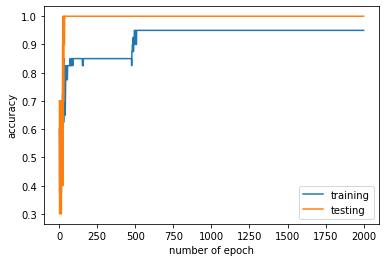

In [8]:
optimizer = torch.optim.Adam(itertools.chain(net.parameters()), lr=0.05)
all_logits = []
train_acc_arr = []
test_acc_arr = []
n_epoch = 2000
features = graph.ndata['feat']
labels = graph.ndata['label']
train_mask = graph.ndata['train_mask']
test_mask = graph.ndata['test_mask']
for epoch in range(n_epoch):

    logits = net(graph, features.type(torch.LongTensor))
    # Save the logits for visualization later
    all_logits.append(logits.detach())
    
    # Note that you should only compute the losses of the nodes in the training set.
    loss = F.cross_entropy(logits[train_mask], labels[train_mask].type(torch.LongTensor))
    pred = logits.argmax(1)
    # Compute accuracy on training/test
    train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
    test_acc = (pred[test_mask] == labels[test_mask]).float().mean()

    # Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_acc_arr.append(train_acc)
    test_acc_arr.append(test_acc)
    # print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))
plt.plot(np.linspace(1,n_epoch,num=n_epoch), train_acc_arr, label = 'training')
plt.plot(np.linspace(1,n_epoch,num=n_epoch), test_acc_arr, label = 'testing')
plt.xlabel('number of epoch')
plt.ylabel('accuracy')
plt.legend()

From the plot above we can see the model is well-trained and converged

#### Visualize the results

Now we want to visualize the model in each epoch.

I use the package networkx for node embedding in each epoch to check the convergence of the model and qualitatively evaluate the performance. Node embedding is a collective term for techniques for mapping graph nodes to vectors in a multidimensional space. To be useful, a good embedding should preserve the structure of the graph.

In each epoch, the position of the node in graph changes with respect to other nodes. The position here are refering to the node in local neighborhood structure and the node in the global location of the graph. A good node embedding should preserve the structure of the graph therefore, by visualizing the embedded vector in each epoch we can check if the model converges and honors the structure based on features and labels of the nodes

In [9]:
nx_G = graph.to_networkx().to_undirected() #the graph is undirected
def draw(i, j): #https://docs.dgl.ai/en/0.2.x/tutorials/basics/1_first.html
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(N):
        pos[v] = all_logits[i][v].numpy()
        cls = pos[v].argmax()
        colors.append(cls1color if cls else cls2color)
    ax[j].cla()
    ax[j].axis('off')
    ax[j].set_title('Epoch: %d' % i)
    nx.draw_networkx(nx_G, pos, node_color=colors,
            with_labels=True, node_size=300, ax=ax[j])

We can see the training process from initial guess, where the nodes are not classified correctly at all, to converging to where the nodes are more or less separable.

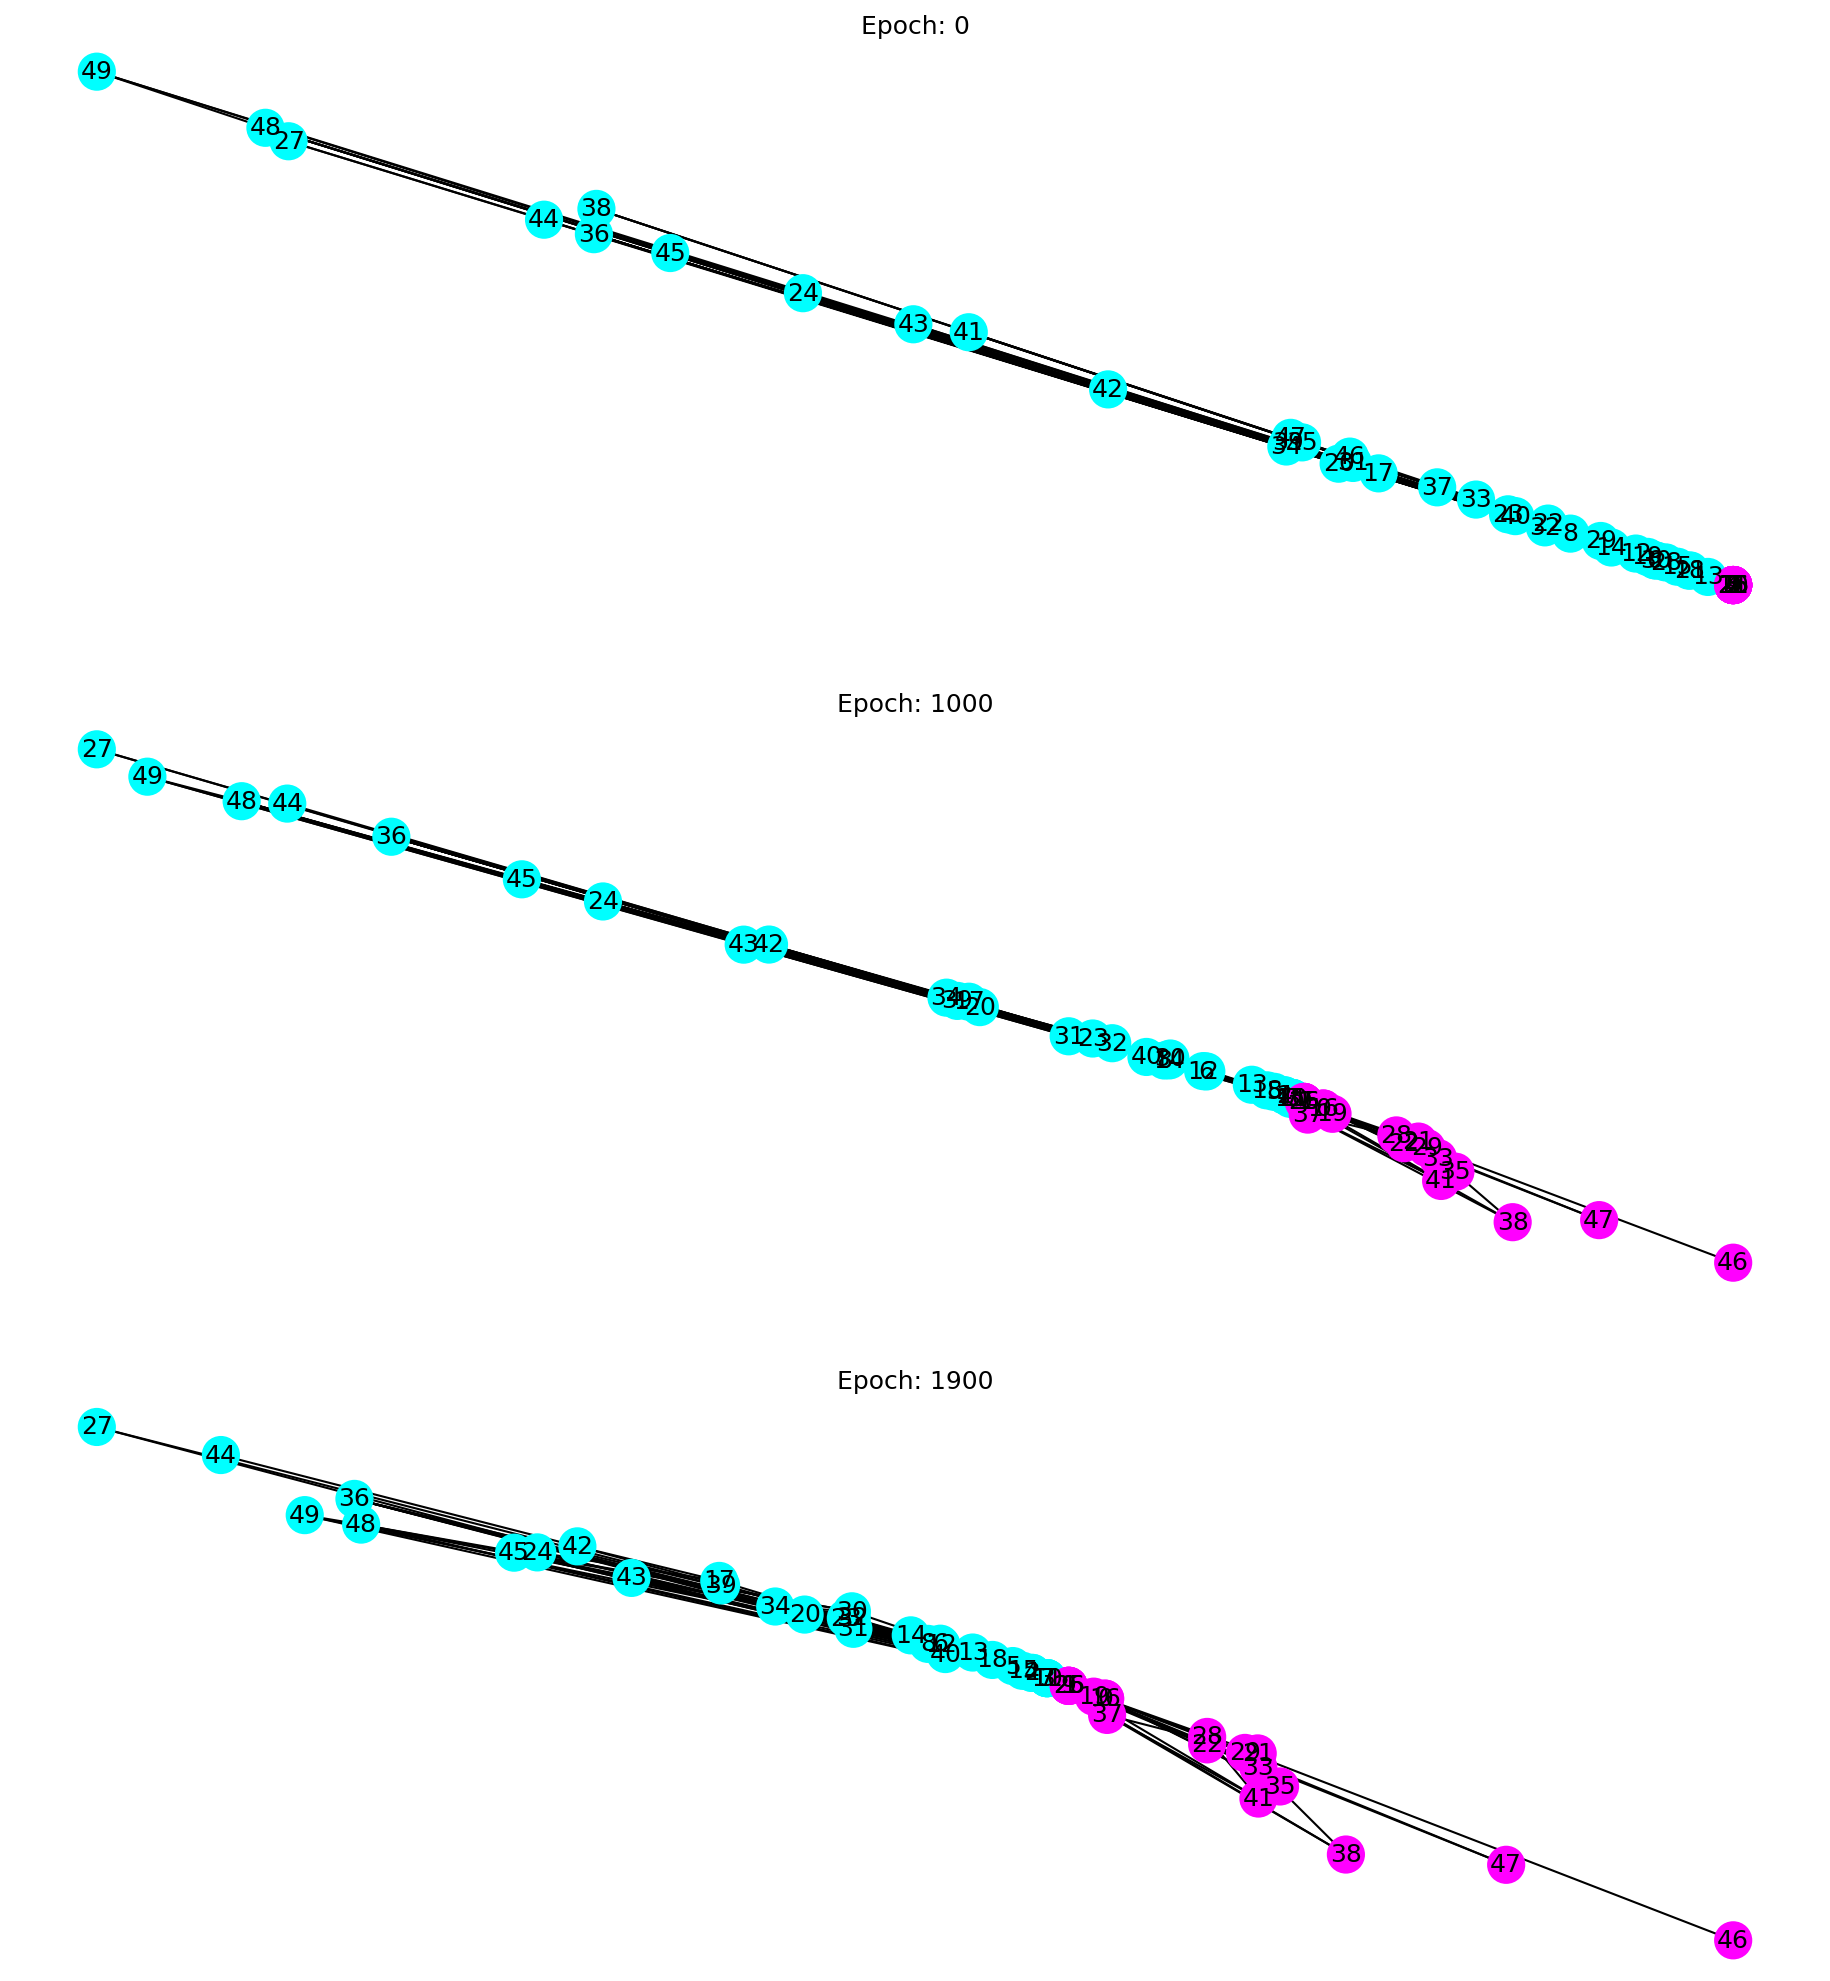

In [10]:
fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots(3)
draw(0, 0)
draw(1000, 1)
draw(1900, 2)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=3.2, wspace=0.2, hspace=0.2)

### Summary

In this workflow, I demonstrate how to use GCN to classify the facies of the well samples given the well network. Graph neural network is computationaly efficient and have more flexibilty to integrate spatial context and domain expertise into the powerful machine learning methods. Future work could be investigate reasonable ways to identify well connections and graph neural network architectures to better leverage the spatial information passed through graph. 


___________________

#### Work Supervised by:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin
